In [1]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import scipy.stats
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as u

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [11]:
#d = pickle.load(open("fitter_params.pickle"))
#params = d
params = dict(files="tuned2_aligned_pulses_selected",
                 tzrmjd_middle='auto',
                 parfile="0337_tempo2_px_optical_dmcorr.par",
                 fit_pos=True,
                 fit_pm=True,
                 fit_px=True,
                 efac=1,
                 t2_astrometry=True,
                 kopeikin=False,
                 ppn_mode='GR',
                 linear_jumps=True,
                 linear_dm=True,
                 fdn_range=(1,5),
                 toa_mode="pipeline")
F = threebody.Fitter(**params)


In [12]:
res = F.residuals(F.best_parameters)
plt.plot(F.mjds, res, ".")

KeyError: 'asini_i'

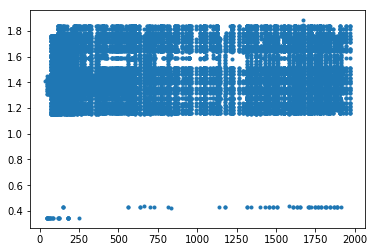

In [13]:
plt.plot(F.mjds, F.freqs/1e9, ".")

In [19]:
def generate_dmx_epochs(mjds, dmx_span=30):
    assert np.all(np.diff(mjds))>=0
    dmx_epochs = []
    for m in mjds:
        if not dmx_epochs or m-dmx_epochs[-1]>dmx_span/2.:
            dmx_epochs.append(m+dmx_span/2.)
    return np.array(dmx_epochs)

def classify_dmx(dmx_epochs, mjds):
    inter = (dmx_epochs[1:]+dmx_epochs[:-1])/2
    return np.searchsorted(inter, mjds)

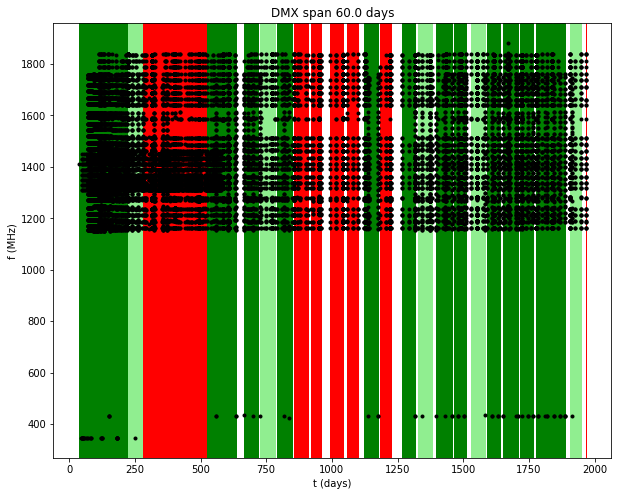

In [42]:
dmx_span = 60
dmx_epochs = generate_dmx_epochs(F.mjds, dmx_span=dmx_span)

ei = 0
first_m = F.mjds[0]
last_m = None
lows = 0
highs = 0
i = 0
while True:
    if i<len(F.mjds):
        m = F.mjds[i]
        f = F.freqs[i]
    if i==len(F.mjds) or (ei<len(dmx_epochs)-1 and
        dmx_epochs[ei+1]-m<m-dmx_epochs[ei]):
        if ei!=-1:
            if highs==0:
                color="darkred"
            elif lows==0:
                color="red"
            elif lows==1:
                color="lightgreen"
            elif lows>1:
                color="green"
            else:
                color="purple"
            #plt.axvline(first_m, color="gray",zorder=-1)
            #plt.axvline(last_m, color="gray",zorder=-1)
            plt.axvspan(first_m, last_m, color=color, zorder=-2)
        ei += 1
        lows = 0
        highs = 0
        first_m = m
    if i==len(F.mjds):
        break
    last_m = m
    if f<1e9:
        lows += 1
    else:
        highs += 1
    i += 1
        
plt.plot(F.mjds, F.freqs/1e6, ".", color='k', zorder=1)
plt.xlabel("t (days)")
plt.ylabel("f (MHz)")
plt.title("DMX span %.1f days" % dmx_span)
plt.gcf().set_size_inches(10,8)
plt.savefig("dmx-span-%.1f.pdf" % dmx_span)

## DMX/IPM fitting

In [63]:
params2 = params.copy()
params2.update(
    dict(dmx_span=180., variable_dm=True, variable_ipm=True))
F2 = threebody.Fitter(**params2)

In [64]:
A, names = F2.compute_linear_matrix()

INFO:threebody:Missing key in parameters: asini_i
INFO:threebody:Missing key in parameters: pb_i
INFO:threebody:Missing key in parameters: eps1_i
INFO:threebody:Missing key in parameters: eps2_i
INFO:threebody:Missing key in parameters: tasc_i
INFO:threebody:Missing key in parameters: acosi_i
INFO:threebody:Missing key in parameters: q_i
INFO:threebody:Missing key in parameters: asini_o
INFO:threebody:Missing key in parameters: pb_o
INFO:threebody:Missing key in parameters: eps1_o
INFO:threebody:Missing key in parameters: eps2_o
INFO:threebody:Missing key in parameters: tasc_o
INFO:threebody:Missing key in parameters: acosi_o
INFO:threebody:Missing key in parameters: delta_lan


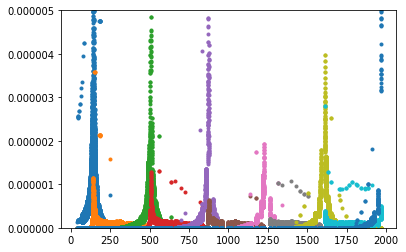

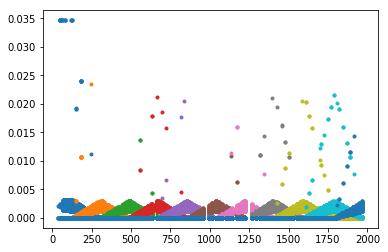

In [65]:
plt.figure()
for i in range(len(names)):
    if names[i].startswith("IPM"):
        plt.plot(F2.mjds, A[:,i], ".", label=names[i])
#plt.legend()
plt.ylim(0,5e-6)
plt.figure()
for i in range(len(names)):
    if names[i].startswith("DM"):
        plt.plot(F2.mjds, A[:,i], ".", label=names[i])
